# Automatic data downloading

* In this example we will show how one can download data from a jupyter notebook.
* The [PhysOcean](https://github.com/gher-ulg/PhysOcean.jl) module provides ways to automatically download data from the World Ocean Database and from CMEMS In-Situ TAC.
* This module can be installed by: 

```julia
Pkg.add("PhysOcean")
```

Import the necessary packages

In [1]:
using PyPlot              # Visualization package
using PhysOcean           # Download data from the World Ocean Database
using divand              # DIVAnd 

Define the time and geospatial bounding box for downloading the data

In [2]:
# resolution (the resolution is only used for DIVAnd analyses)
dx = dy = 0.25   # medium size test 

# vectors defining the longitude and latitudes grids
# Here longitude and latitude correspond to the Mediterranean Sea
lonr = -7:dx:37
latr = 30:dy:46

# time range of the in-situ data
timerange = [Date(2016,1,1),Date(2016,12,31)];

In [3]:
# Name of the variable
varname = "Salinity"

"Salinity"

Please use your own email address (!) 😉     
It is only use to get notified once the dataset is ready.

In [4]:
# Email for downloading the data
email = "a.barth@ulg.ac.be"

"a.barth@ulg.ac.be"

Define the directory where the results will be saved.    
The tilde ~ will be replaced (expanded) by your home user directory.      
The command `mkpath` will create this path if necessary (including parent path).

In [5]:
basedir = expanduser("~/Downloads/WOD/Med-2016-3")
mkpath(basedir)

## Download the data

* World Ocean Database: example for bulk access data by simulating a web-user.
* Downloading can take several tens of minutes.
* SeaDataNet will provide a dedicated machine-to-machine interface during the SeaDataCloud project

In [6]:
?WorldOceanDatabase.download

```
dirnames,indexnames = WorldOceanDatabase.download(lonrange,latrange,timerange,
  variable,email,basedir)
```

Download data using the NODC web-service. The range parameters are vectors from with the frist element is the lower bound and the last element is the upper bound. The parameters of the functions will  be transmitted to nodc.noaa.gov (http://www.noaa.gov/privacy.html). Note that no XBT corrections are applied. The table below show the avialable variable and their units.

| Variables                          | Unit     |
|:---------------------------------- |:-------- |
| Temperature                        | °C       |
| Salinity                           | unitless |
| Oxygen                             | ml l⁻¹   |
| Phosphate                          | µM       |
| Silicate                           | µM       |
| Nitrate and Nitrate+Nitrite        | µM       |
| pH                                 | unitless |
| Chlorophyll                        | µg l⁻¹   |
| Plankton                           | multiple |
| Alkalinity                         | meq l⁻¹  |
| Partial Pressure of Carbon Dioxide | µatm     |
| Dissolved Inorganic Carbon         | mM       |
| Transmissivity                     | m⁻¹      |
| Pressure                           | dbar     |
| Air temperature                    | °C       |
| CO2 warming                        | °C       |
| CO2 atmosphere                     | ppm      |
| Air pressure                       | mbar     |
| Tritium                            | TU       |
| Helium                             | nM       |
| Delta Helium-3                     | %        |
| Delta Carbon-14                    | ᵒ/ᵒᵒ     |
| Delta Carbon-13                    | ᵒ/ᵒᵒ     |
| Argon                              | nM       |
| Neon                               | nM       |
| Chlorofluorocarbon 11 (CFC 11)     | pM       |
| Chlorofluorocarbon 12 (CFC 12)     | pM       |
| Chlorofluorocarbon 113 (CFC 113)   | pM       |
| Delta Oxygen-18                    | ᵒ/ᵒᵒ     |


* comment this line (or skip this cell) if the data has already been downloaded

In [7]:
WorldOceanDatabase.download(lonr,latr,timerange,varname,email,basedir);

PFL is now available
CTD is now available
GLD is now available


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30.2M  100 30.2M    0     0  6853k      0  0:00:04  0:00:04 --:--:-- 6854k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146k  100  146k    0     0   121k      0  0:00:01  0:00:01 --:--:--  121k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32.6M  100 32.6M    0     0  5845k      0  0:00:05  0:00:05 --:--:-- 7387k


# Load data
* Load the data into memory and perform (potentially) an additional subsetting

In [8]:
# load all data under basedir as a double-precision floating point variable
val,lon,lat,depth,time,ids = WorldOceanDatabase.load(Float64,basedir,varname);

Number of data points

In [9]:
size(val)

(4440734,)

Additional sub-setting based on time and depth for plotting

In [10]:
# depth range levels
depthr = [0.,20.]
# month range (January to March)

timer = [1,3]
# additional sub-setting and discard bogus negative temperatures
sel = ((val .> 0 )
       .& (minimum(depthr) .<= depth .<= maximum(depthr))
       .& (minimum(timer) .<= Dates.month.(time) .<= maximum(timer)))

valsel = val[sel]
lonsel = lon[sel]
latsel = lat[sel]
depthsel = depth[sel]
timesel = time[sel]
idssel = ids[sel];

In [11]:
checkobs((lonsel,latsel,depthsel,timesel),valsel,idssel)

              minimum and maximum of obs. dimension 1: (-6.86899995803833, 36.989349365234375)
              minimum and maximum of obs. dimension 2: (31.738000869750977, 45.922000885009766)
              minimum and maximum of obs. dimension 3: (-0.0, 19.999536514282227)
              minimum and maximum of obs. dimension 4: (2016-01-01T00:00:00, 2016-03-31T23:54:21.959)
                          minimum and maximum of data: (17.80699920654297, 39.37672805786133)


Number of selected data points

In [12]:
length(valsel)

36531

Download bathymetry for plotting

In [13]:
bathname = "gebco_30sec_16.nc"

if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/o0vinoQutAC7eb0/download",bathname)
else
    info("Bathymetry file already downloaded")
end

bathisglobal = true

# Extract the bathymetry for plotting
bx,by,b = divand.extract_bath(bathname,bathisglobal,lonr,latr);

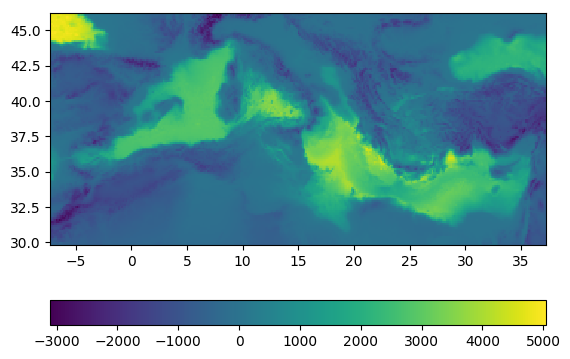

In [52]:
pcolor(bx,by,b')
#contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
# compute and set the correct aspect ratio
aspect_ratio = 1/cos(mean(latr) * pi/180)
gca()[:set_aspect](aspect_ratio)
colorbar(orientation = "horizontal");

Plotting gotchas
* `colorbar()` referes to the last added item. If the last added item is the land-sea mask, the colorbar will be all gray
* maps look nicer if you set the corresponding aspect ratio based on the average latitude `mean(latr)`.

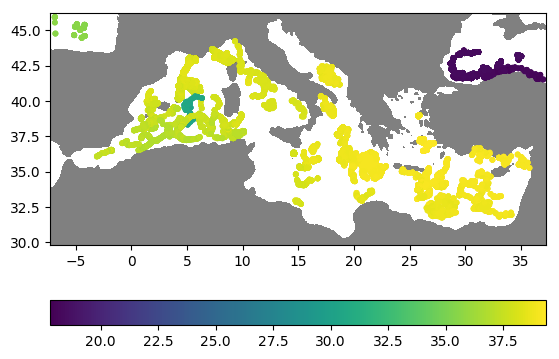

In [53]:
contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
scatter(lonsel,latsel,10,valsel); 

# compute and set the correct aspect ratio
aspect_ratio = 1/cos(mean(latr) * pi/180)
gca()[:set_aspect](aspect_ratio)
colorbar(orientation = "horizontal");

# Check for duplicates

There are two ways to call the function `checkduplicates`:

In [16]:
?divand.Quadtrees.checkduplicates

```
dupl = checkduplicates(x,value,delta,deltavalue)
```

Based the coordinates `x` (a tuple of longitude `lons`, latitudes `lats`, depth (`zs`)  and time (`times` vector of `DateTime`)) check of points who are in the same spatio-temporal bounding  box of a length `delta`. `delta` is a vector with 4 elements corresponding to  longitude, latitude, depth and time (in days). `dupl` a vector of vectors containing indices of the duplicates.

```
dupl = checkduplicates(x1,value1,x2,v2,value2,delta,deltavalue)
```

Report duplicate of observation in data set (x2,v2) which are also in data set  (x1,v1). `x1` and `x2` is a tuple of vectors with the cooridantes and `v1` and `v2` the  corresponding values. 


In [61]:
val_ODV,lon_ODV,lat_ODV,depth_ODV,time_ODV,ids_ODV = ODVspreadsheet.load(Float64,["small_ODV_sample.txt"],
                           ["Water body salinity"]; nametype = :localname );

Look for duplicates
* within 0.01 degree (about 1km)
* within 0.01 m depth
* within 1 minute
Difference in value is 0.01 psu

In [62]:
dupl = divand.Quadtrees.checkduplicates((lon_ODV,lat_ODV,depth_ODV,time_ODV),val_ODV,(lon,lat,depth,time),val,(0.01,0.01,0.01,1/(24*60)),0.01);

In [63]:
size(val)

(4440734,)

In [64]:
size(dupl)

(4440734,)

* `dupl` is an array of the same length as `val`
* If i-th element of `dupl`, is an empty list, then the i-th element in `val` is probably not a duplicate
* Otherwise, then the i-th element in `val` is probably a duplicate of the element `val_ODV` with the indices `dupl[i]`.

In [65]:
index = find(.!isempty.(dupl));

Number of duplicate candidates

In [66]:
length(index)

4191

Check the first reported duplicate

In [67]:
index_WOD = index[1]

3158229

Its coordinate and values from the ODV file

In [68]:
lon[index_WOD],lat[index_WOD],depth[index_WOD],time[index_WOD],val[index_WOD]

(17.885482788085938, 35.23445129394531, 2.4818837642669678, 2016-06-14T10:38:27.239, 38.85300064086914)

They are quite close to the data point with the index:

In [69]:
dupl[index_WOD]

1-element Array{Int64,1}:
 20508

In [70]:
index_ODV = dupl[index_WOD][1]

20508

In [72]:
lon2[index_ODV],lat2[index_ODV],depth2[index_ODV],time2[index_ODV],val2[index_ODV]

(17.88548, 35.23445, 2.48189, 2016-06-14T10:39:00, 38.853)

Indeed, it is quite likely that they are duplicates


Combine the dataset and retain only new points from WOD

In [78]:
newpoints = find(isempty.(dupl));
@show length(newpoints)
lon_combined   = [lon_ODV;   lon[newpoints]];
lat_combined   = [lat_ODV;   lat[newpoints]];
depth_combined = [depth_ODV; depth[newpoints]];
time_combined  = [time_ODV;  time[newpoints]];
val_combined   = [val_ODV;   val[newpoints]];
ids_combined   = [ids_ODV;   ids[newpoints]];


length(newpoints) = 4436543
